In [5]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import quantstats as qs

In [15]:
with open('A2C_iter_1', 'rb') as f:
    A2C_iter_1 = pickle.load(f)

In [16]:
with open('A2C_iter_2', 'rb') as f:
    A2C_iter_2 = pickle.load(f)

In [6]:
AUDUSD = pd.read_csv('../../Datasets/AUDUSD_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
EURUSD = pd.read_csv('../../Datasets/EURUSD_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
GBPUSD = pd.read_csv('../../Datasets/GBPUSD_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
NZDUSD = pd.read_csv('../../Datasets/NZDUSD_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
USDCAD = pd.read_csv('../../Datasets/USDCAD_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
USDCHF = pd.read_csv('../../Datasets/USDCHF_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')
USDJPY = pd.read_csv('../../Datasets/USDJPY_Candlestick_1_Hour_BID_01.01.2007-25.12.2021.csv')

In [7]:
# 1. Limpiamos el dataset ya que las fechas como vienen están mal
# 2. Asignamos el conjunto de entrenamiento y test de cada par de divisas. 
# El train va desde Junio 2019 a Junio 2021 y el test de Junio 2021 a Diciembre 2021

df_pair = {}
df_pair['AUDUSD'] = AUDUSD
df_pair['EURUSD'] = EURUSD
df_pair['GBPUSD'] = GBPUSD
df_pair['NZDUSD'] = NZDUSD
df_pair['USDCAD'] = USDCAD
df_pair['USDCHF'] = USDCHF
df_pair['USDJPY'] = USDJPY
df_train = {}
df_test = {}
names = list(df_pair.keys())
for i in range(len(df_pair)):
    df = df_pair[names[i]]
    df = df.drop(df[df.Volume == 0].index)
    df = df.rename(columns={'Gmt time': 'Date'})
    #AUDUSD['Date'] =  pd.to_times(AUDUSD['Date'])
    #AUDUSD.set_index('Date', inplace=True)

    df['Day'] = df['Date'].astype(str).str[0:2]
    df['Month'] = df['Date'].astype(str).str[3:5]
    df['Year'] = df['Date'].astype(str).str[6:10]
    df['Hour'] = df['Date'].astype(str).str[11:13]
    df['Date'] = pd.to_datetime(df[['Day', 'Month', 'Year', 'Hour']])
    df.set_index('Date', inplace=True)
    df = df[["Open","High","Low","Close","Volume"]]
    df_pair[names[i]] = df
    # Train
    df_train[names[i]] = df_pair[names[i]].query("20190630 < index < 20210701")
    # Test
    df_test[names[i]] = df_pair[names[i]].query("20210701 < index < 20211226")

### Análisis de resultados

In [40]:
policy = list(A2C_iter_1[names[0]].keys())

sharpe_iter_1 = {}
sharpe_iter_2 = {}

for i in range(len(names)):
    sharpe_iter_1[names[i]] = {}
    sharpe_iter_2[names[i]] = {}

for i in range(len(A2C_iter_1)):
    for j in range(len(policy)):
        sharpe_iter_1[names[i]][policy[j]] = qs.stats.sharpe(A2C_iter_1[names[i]][policy[j]])
        sharpe_iter_2[names[i]][policy[j]] = qs.stats.sharpe(A2C_iter_2[names[i]][policy[j]])

In [65]:
best_per_iter = {}

for i in range(len(names)):
    best_per_iter[names[i]] = {}
    
for i in range(len(names)):
    max_key = max(sharpe_iter_1[names[i]], key=sharpe_iter_1[names[i]].get)
    max_value = max(sharpe_iter_1[names[i]].values())
    best_per_iter[names[i]]['iter_1_'+max_key] = max_value
    
    max_key = max(sharpe_iter_2[names[i]], key=sharpe_iter_2[names[i]].get)
    max_value = max(sharpe_iter_2[names[i]].values())
    best_per_iter[names[i]]['iter_2_'+max_key] = max_value

In [69]:
best_per_iter

{'AUDUSD': {'iter_1_A2C_MlpLstmPolicy': -0.2644162073393561,
  'iter_2_A2C_MlpLstmPolicy': 0.11751431411604382},
 'EURUSD': {'iter_1_A2C_MlpLnLstmPolicy': 0.07262082175402762,
  'iter_2_A2C_MlpLstmPolicy': 0.3942134571738222},
 'GBPUSD': {'iter_1_A2C_MlpLstmPolicy': 0.23120688491903638,
  'iter_2_A2C_MlpLstmPolicy': 0.21477272451673915},
 'NZDUSD': {'iter_1_A2C_MlpLnLstmPolicy': -0.9027062184674073,
  'iter_2_A2C_MlpLstmPolicy': 0.028908126263940893},
 'USDCAD': {'iter_1_A2C_MlpPolicy': -1.4518423522117627,
  'iter_2_A2C_MlpLnLstmPolicy': -0.5664605479871856},
 'USDCHF': {'iter_1_A2C_MlpLstmPolicy': -1.988730117436805,
  'iter_2_A2C_MlpLnLstmPolicy': -1.743068103175562},
 'USDJPY': {'iter_1_A2C_MlpLstmPolicy': 0.10585222882584219,
  'iter_2_A2C_MlpPolicy': -0.1299548744725268}}

### ¿Se ha mejorado?

In [70]:
best_iter = {}

for i in range(len(names)):
    best_iter[names[i]] = {}

for i in range(len(names)):
    max_key = max(best_per_iter[names[i]], key=best_per_iter[names[i]].get)
    max_value = max(best_per_iter[names[i]].values())
    best_iter[names[i]][max_key] = max_value

In [72]:
best_iter

{'AUDUSD': {'iter_2_A2C_MlpLstmPolicy': 0.11751431411604382},
 'EURUSD': {'iter_2_A2C_MlpLstmPolicy': 0.3942134571738222},
 'GBPUSD': {'iter_1_A2C_MlpLstmPolicy': 0.23120688491903638},
 'NZDUSD': {'iter_2_A2C_MlpLstmPolicy': 0.028908126263940893},
 'USDCAD': {'iter_2_A2C_MlpLnLstmPolicy': -0.5664605479871856},
 'USDCHF': {'iter_2_A2C_MlpLnLstmPolicy': -1.743068103175562},
 'USDJPY': {'iter_1_A2C_MlpLstmPolicy': 0.10585222882584219}}

In [73]:
# Se ha mejorado en 5/7 pares, lo que supone un 71.% de los casos

### ¿Se ha ganado pasta en alguno?

In [76]:
# Creamos el diccionario de resultados del mejor en cada par de divisas
top_performance = {}
for i in range(len(names)):
    top_performance[names[i]] = {}
top_performance[names[0]]['iter_2_A2C_MlpLstmPolicy'] = A2C_iter_2[names[0]]['A2C_MlpLstmPolicy']
top_performance[names[1]]['iter_2_A2C_MlpLstmPolicy'] = A2C_iter_2[names[1]]['A2C_MlpLstmPolicy']
top_performance[names[2]]['iter_1_A2C_MlpLstmPolicy'] = A2C_iter_1[names[2]]['A2C_MlpLstmPolicy']
top_performance[names[3]]['iter_2_A2C_MlpLstmPolicy'] = A2C_iter_2[names[3]]['A2C_MlpLstmPolicy']
top_performance[names[4]]['iter_2_A2C_MlpLnLstmPolicy'] = A2C_iter_2[names[4]]['A2C_MlpLnLstmPolicy']
top_performance[names[5]]['iter_2_A2C_MlpLnLstmPolicy'] = A2C_iter_2[names[5]]['A2C_MlpLnLstmPolicy']
top_performance[names[6]]['iter_1_A2C_MlpLstmPolicy'] = A2C_iter_1[names[6]]['A2C_MlpLstmPolicy']

                           Strategy
-------------------------  ----------
Start Period               2021-07-05
End Period                 2021-12-24
Risk-Free Rate             0.0%
Time in Market             2.0%

Cumulative Return          2.43%
CAGR﹪                     5.22%

Sharpe                     0.12
Smart Sharpe               0.12
Sortino                    0.2
Smart Sortino              0.2
Sortino/√2                 0.14
Smart Sortino/√2           0.14
Omega                      1.2

Max Drawdown               -4.75%
Longest DD Days            111
Volatility (ann.)          1.87%
Calmar                     1.1
Skew                       7.93
Kurtosis                   372.27

Expected Daily %           0.0%
Expected Monthly %         0.4%
Expected Yearly %          2.43%
Kelly Criterion            6.35%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.19%
Expected Shortfall (cVaR)  -0.19%

Gain/Pain Ratio            0.22
Gain/Pain (1M)             0.58

Payof

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-08-24,2021-10-21,2021-12-14,111,-4.751270,-3.939714
2,2021-12-14,2021-12-24,2021-12-24,10,-1.395546,-0.495551
3,2021-07-26,2021-08-05,2021-08-23,27,-0.975734,-0.893955
4,2021-07-09,2021-07-09,2021-07-20,11,-0.667844,0.000000
5,2021-07-05,2021-07-05,2021-07-08,2,-0.119681,-0.099773


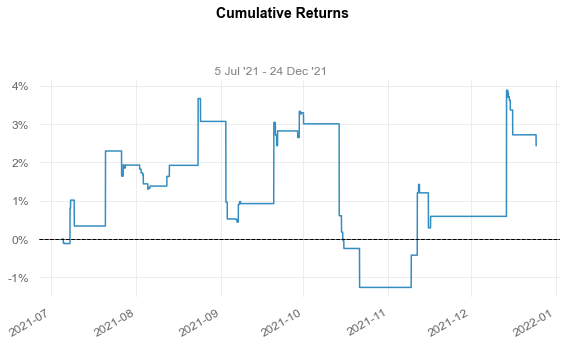

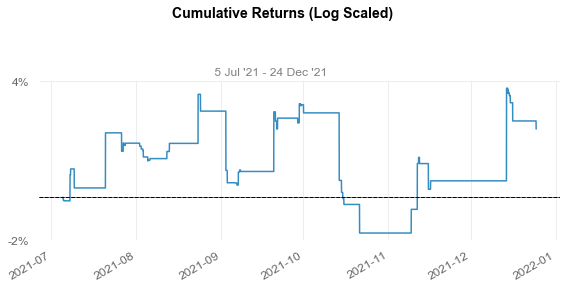

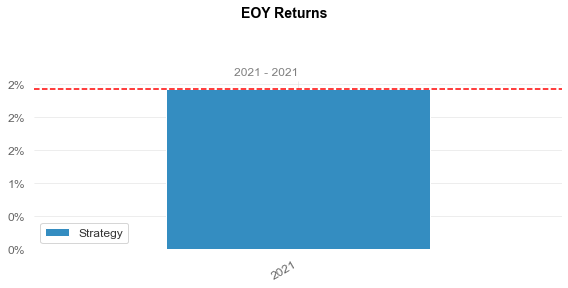

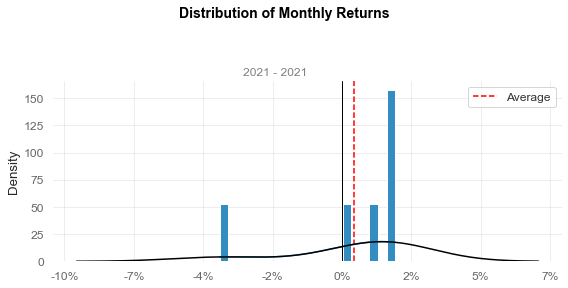

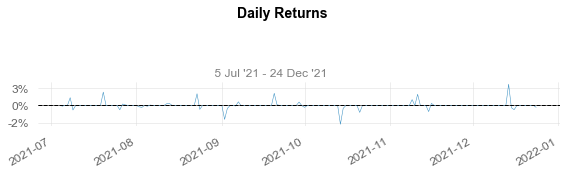

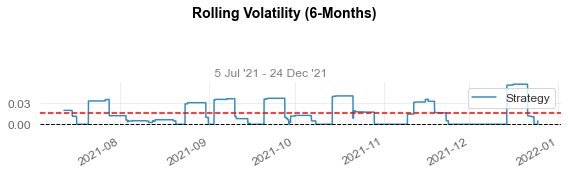

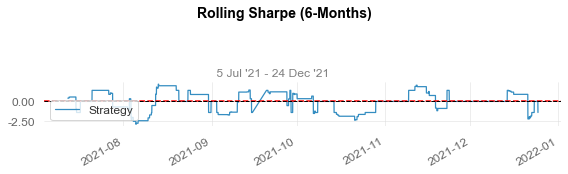

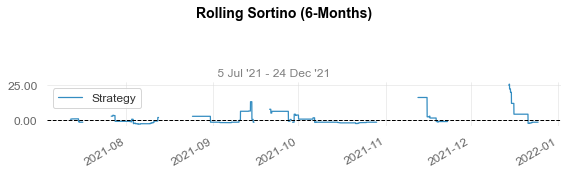

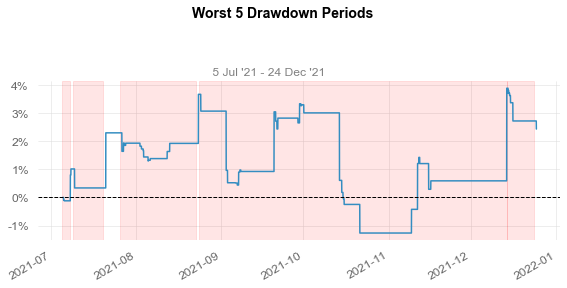

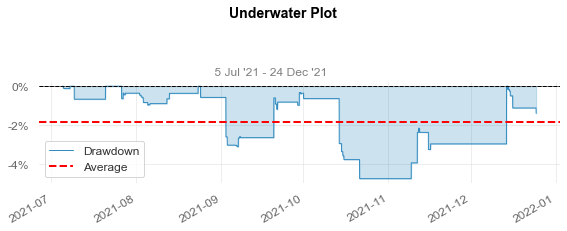

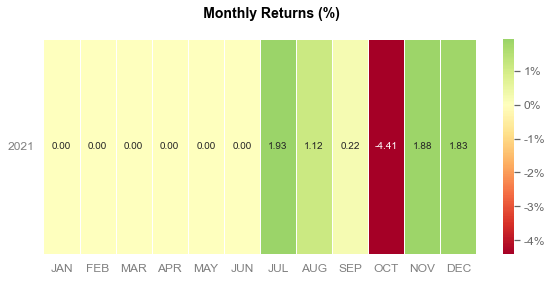

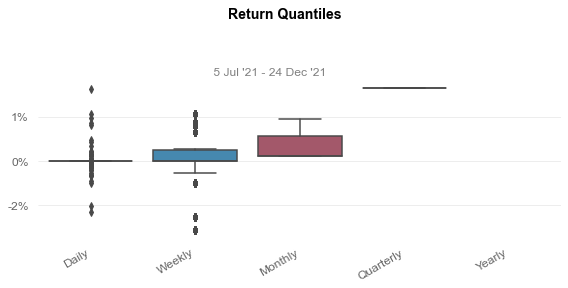

In [79]:
qs.reports.full(top_performance[names[0]]['iter_2_A2C_MlpLstmPolicy'])

                           Strategy
-------------------------  ----------
Start Period               2021-07-05
End Period                 2021-12-24
Risk-Free Rate             0.0%
Time in Market             1.0%

Cumulative Return          4.57%
CAGR﹪                     9.96%

Sharpe                     0.39
Smart Sharpe               0.39
Sortino                    1.09
Smart Sortino              1.09
Sortino/√2                 0.77
Smart Sortino/√2           0.77
Omega                      2.54

Max Drawdown               -0.96%
Longest DD Days            58
Volatility (ann.)          0.97%
Calmar                     10.4
Skew                       20.04
Kurtosis                   565.72

Expected Daily %           0.0%
Expected Monthly %         0.75%
Expected Yearly %          4.57%
Kelly Criterion            30.3%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.1%
Expected Shortfall (cVaR)  -0.1%

Gain/Pain Ratio            1.54
Gain/Pain (1M)             9.06

Pa

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-11-28,2021-12-24,2021-12-24,25,-0.957767,-0.631189
2,2021-07-12,2021-08-03,2021-08-26,44,-0.749747,-0.610085
3,2021-08-30,2021-08-31,2021-10-27,58,-0.525335,-0.410744
4,2021-07-06,2021-07-06,2021-07-07,1,-0.210548,0.000000


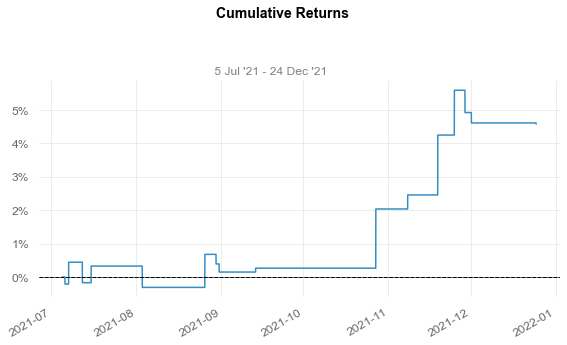

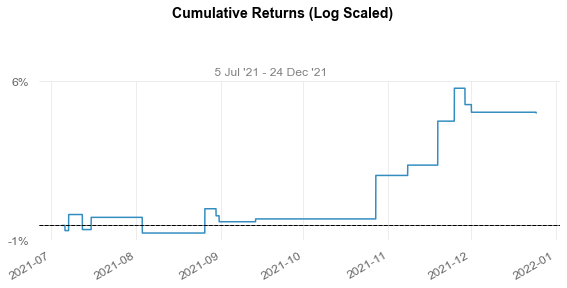

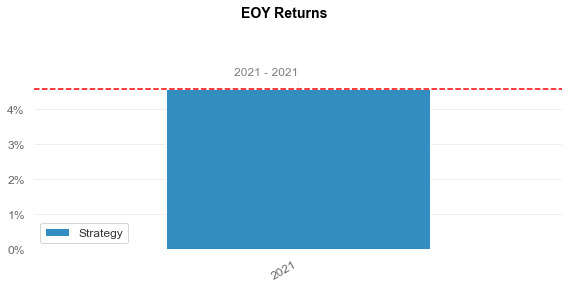

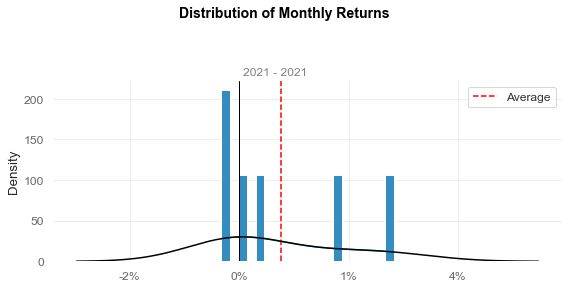

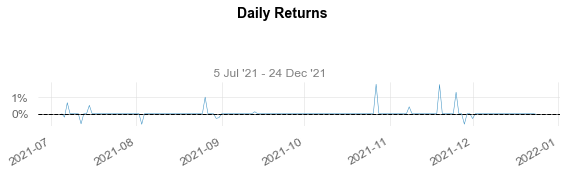

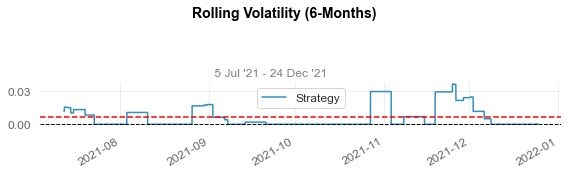

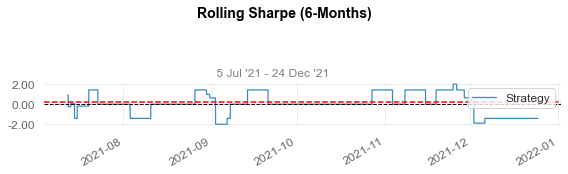

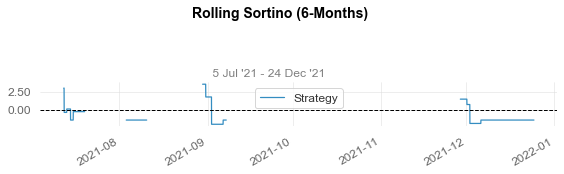

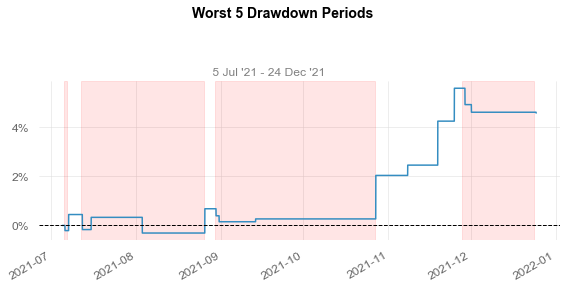

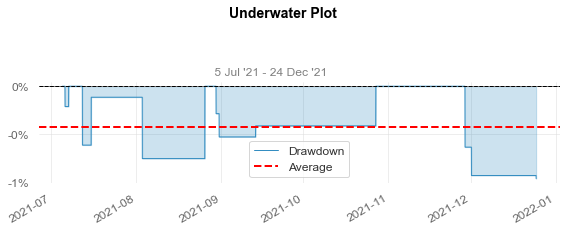

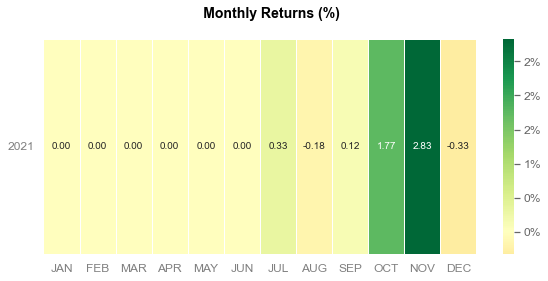

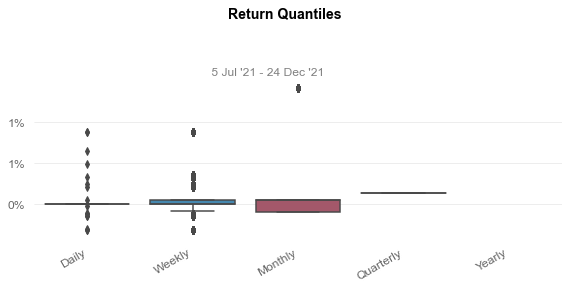

In [80]:
qs.reports.full(top_performance[names[1]]['iter_2_A2C_MlpLstmPolicy'])

                           Strategy
-------------------------  ----------
Start Period               2021-07-05
End Period                 2021-12-24
Risk-Free Rate             0.0%
Time in Market             1.0%

Cumulative Return          3.71%
CAGR﹪                     8.04%

Sharpe                     0.23
Smart Sharpe               0.23
Sortino                    0.5
Smart Sortino              0.5
Sortino/√2                 0.35
Smart Sortino/√2           0.35
Omega                      1.76

Max Drawdown               -1.52%
Longest DD Days            55
Volatility (ann.)          1.37%
Calmar                     5.3
Skew                       18.99
Kurtosis                   714.84

Expected Daily %           0.0%
Expected Monthly %         0.61%
Expected Yearly %          3.71%
Kelly Criterion            20.3%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.14%
Expected Shortfall (cVaR)  -0.14%

Gain/Pain Ratio            0.76
Gain/Pain (1M)             2.72

Pay

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-08-23,2021-09-02,2021-09-29,37,-1.516142,-0.185328
2,2021-10-11,2021-10-11,2021-12-06,55,-1.380449,-0.410251
3,2021-12-07,2021-12-24,2021-12-24,17,-1.086774,-0.046873
4,2021-07-09,2021-07-13,2021-08-20,42,-0.724144,-0.535719


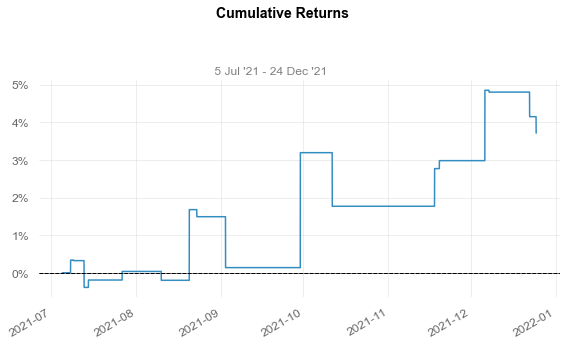

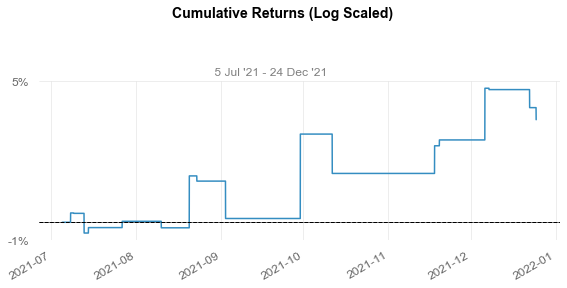

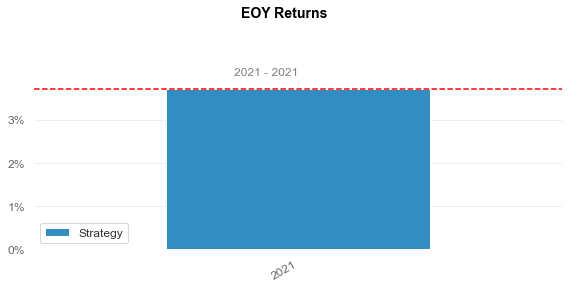

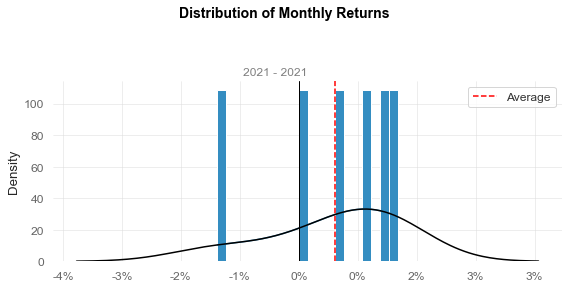

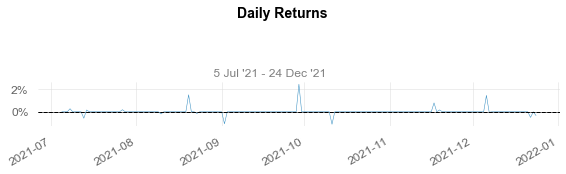

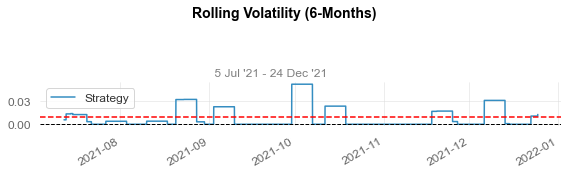

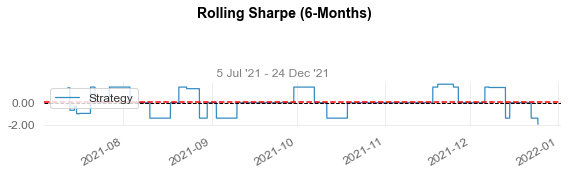

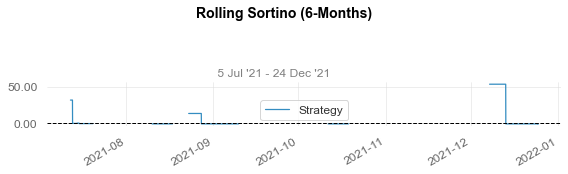

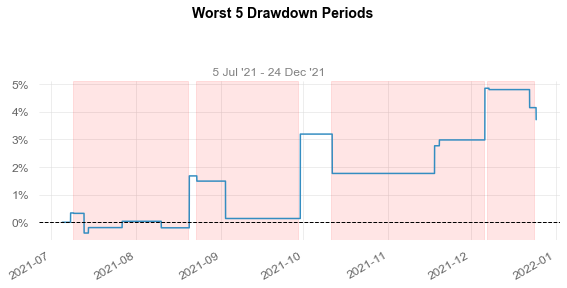

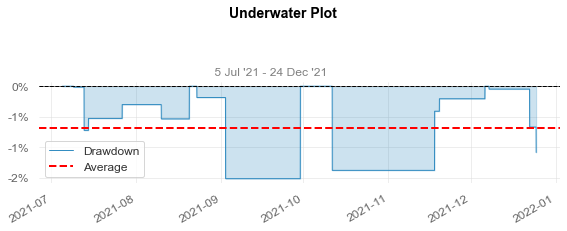

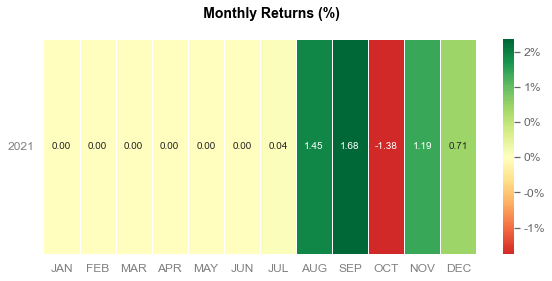

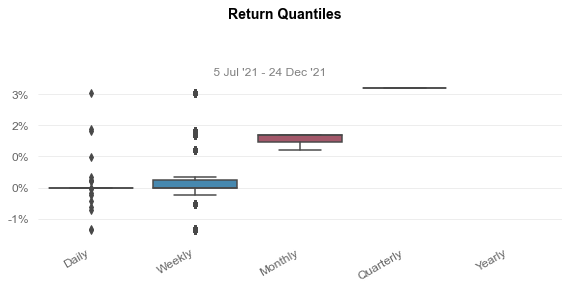

In [81]:
qs.reports.full(top_performance[names[2]]['iter_1_A2C_MlpLstmPolicy'])

                           Strategy
-------------------------  ----------
Start Period               2021-07-05
End Period                 2021-12-24
Risk-Free Rate             0.0%
Time in Market             3.0%

Cumulative Return          0.41%
CAGR﹪                     0.86%

Sharpe                     0.03
Smart Sharpe               0.03
Sortino                    0.05
Smart Sortino              0.05
Sortino/√2                 0.03
Smart Sortino/√2           0.03
Omega                      1.03

Max Drawdown               -5.34%
Longest DD Days            108
Volatility (ann.)          1.64%
Calmar                     0.16
Skew                       6.02
Kurtosis                   260.81

Expected Daily %           0.0%
Expected Monthly %         0.07%
Expected Yearly %          0.41%
Kelly Criterion            1.57%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.17%
Expected Shortfall (cVaR)  -0.17%

Gain/Pain Ratio            0.04
Gain/Pain (1M)             0.08



None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-08-20,2021-10-20,2021-12-06,108,-5.340818,-5.145123
2,2021-07-21,2021-08-11,2021-08-19,28,-2.275936,-1.990281
3,2021-12-08,2021-12-24,2021-12-24,16,-1.444921,-0.856298
4,2021-07-16,2021-07-16,2021-07-20,3,-0.782913,0.000000


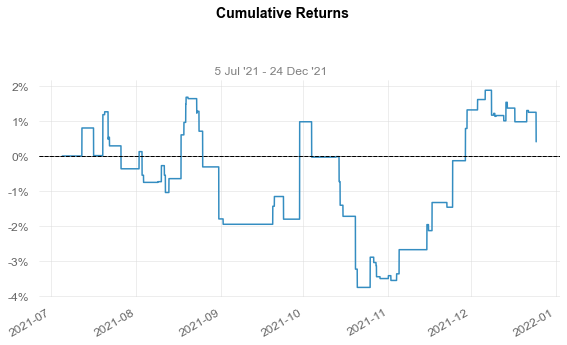

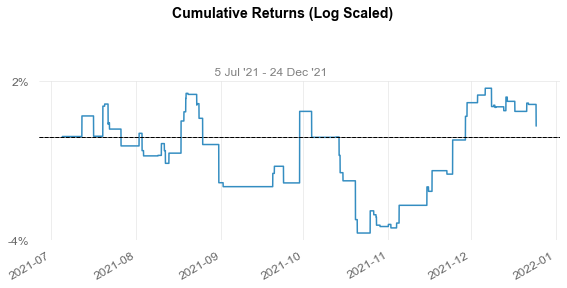

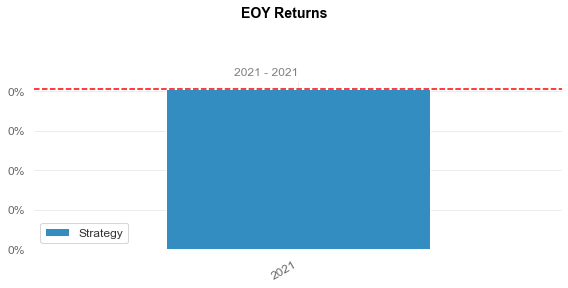

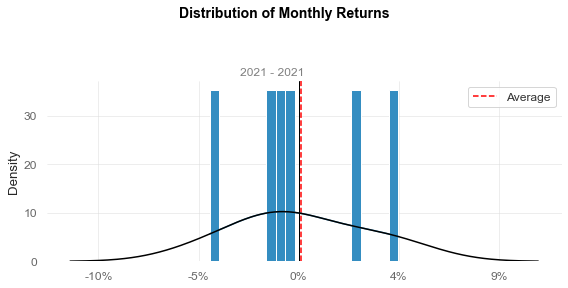

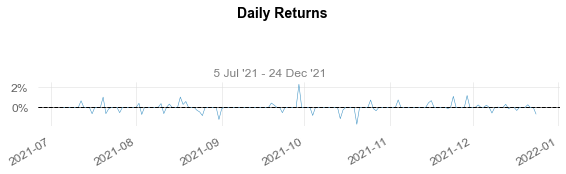

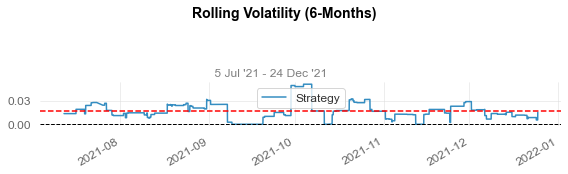

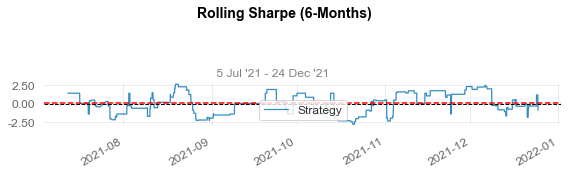

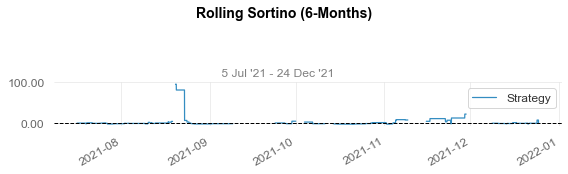

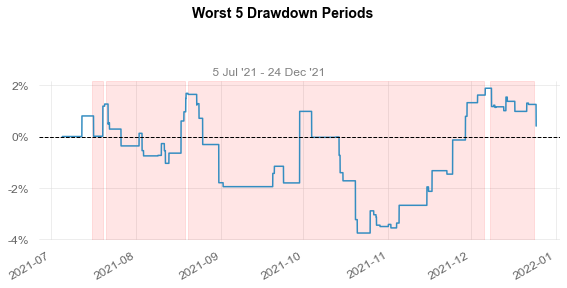

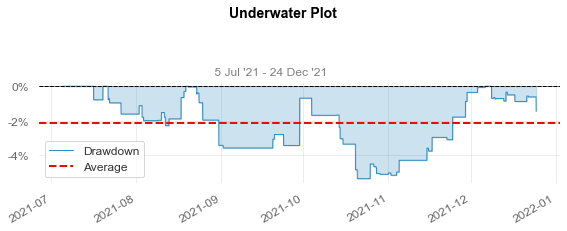

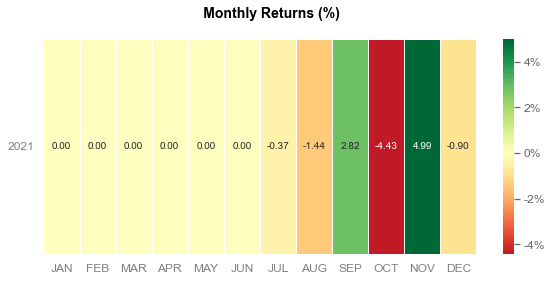

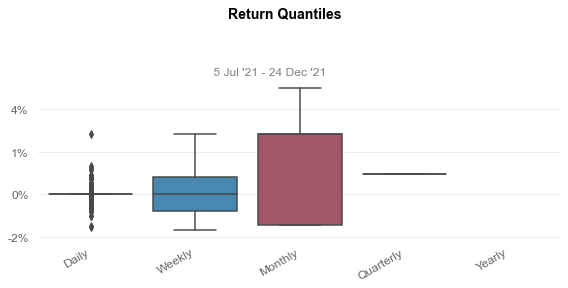

In [82]:
qs.reports.full(top_performance[names[3]]['iter_2_A2C_MlpLstmPolicy'])

                           Strategy
-------------------------  ----------
Start Period               2021-07-05
End Period                 2021-12-24
Risk-Free Rate             0.0%
Time in Market             1.0%

Cumulative Return          -0.6%
CAGR﹪                     -1.26%

Sharpe                     -0.57
Smart Sharpe               -0.57
Sortino                    -0.57
Smart Sortino              -0.57
Sortino/√2                 -0.4
Smart Sortino/√2           -0.4
Omega                      0.03

Max Drawdown               -0.61%
Longest DD Days            169
Volatility (ann.)          0.09%
Calmar                     -2.06
Skew                       -36.19
Kurtosis                   1484.55

Expected Daily %           -0.0%
Expected Monthly %         -0.1%
Expected Yearly %          -0.6%
Kelly Criterion            -703.66%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.01%
Expected Shortfall (cVaR)  -0.01%

Gain/Pain Ratio            -0.97
Gain/Pain (1M)     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-07-08,2021-12-08,2021-12-24,169,-0.613852,-0.594969


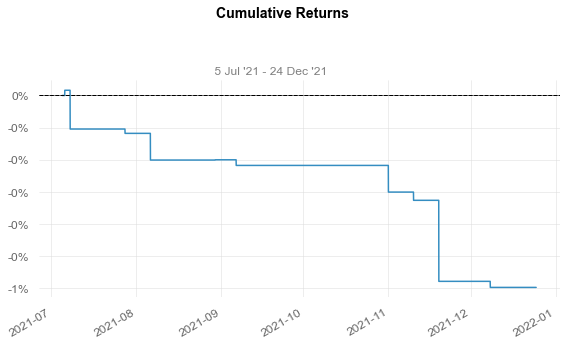

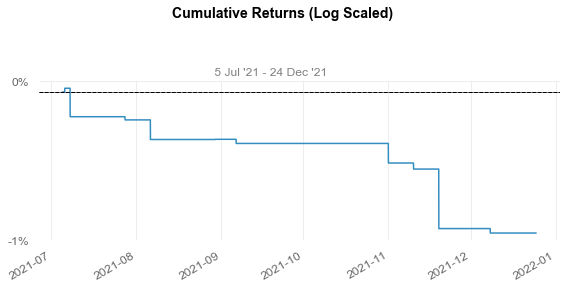

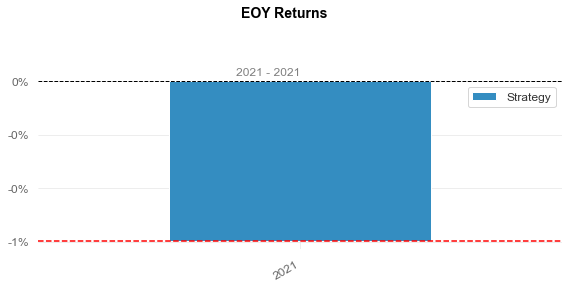

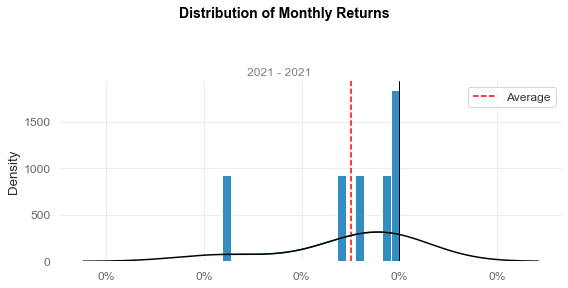

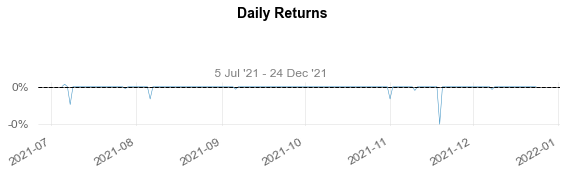

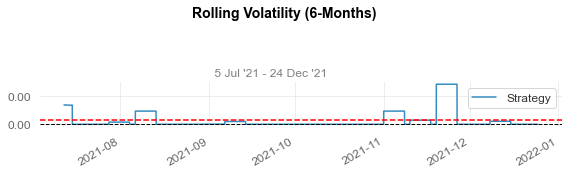

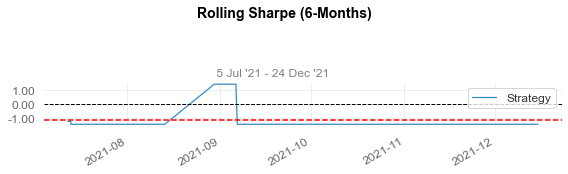

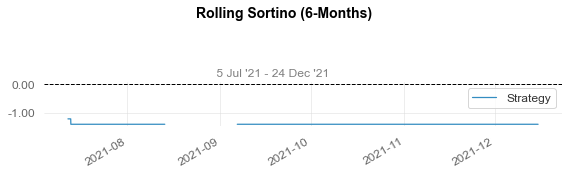

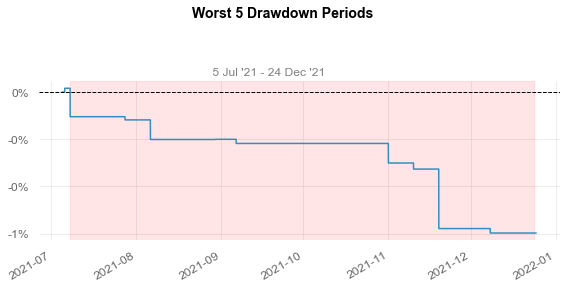

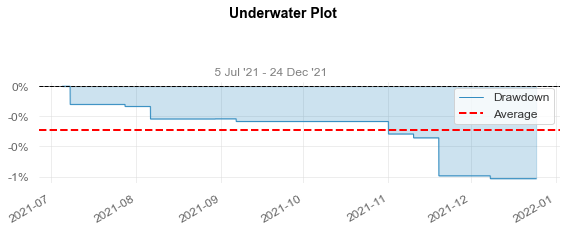

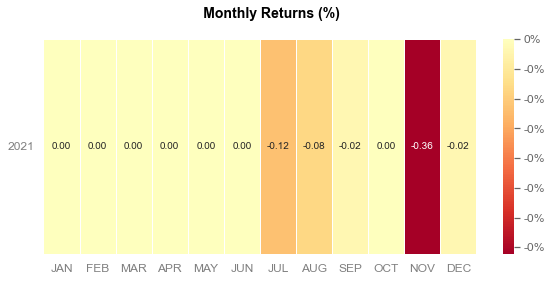

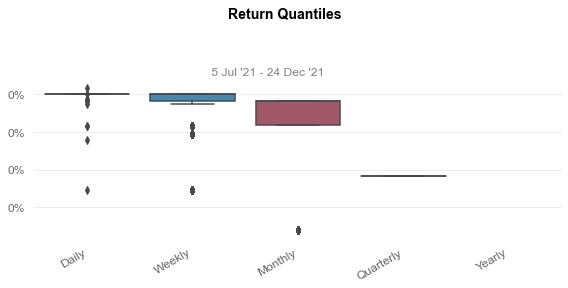

In [84]:
qs.reports.full(top_performance[names[4]]['iter_2_A2C_MlpLnLstmPolicy'])

                           Strategy
-------------------------  ----------
Start Period               2021-07-05
End Period                 2021-12-24
Risk-Free Rate             0.0%
Time in Market             24.0%

Cumulative Return          -18.89%
CAGR﹪                     -35.87%

Sharpe                     -1.74
Smart Sharpe               -1.72
Sortino                    -2.29
Smart Sortino              -2.26
Sortino/√2                 -1.62
Smart Sortino/√2           -1.6
Omega                      0.5

Max Drawdown               -19.16%
Longest DD Days            169
Volatility (ann.)          1.01%
Calmar                     -1.87
Skew                       0.9
Kurtosis                   37.95

Expected Daily %           -0.01%
Expected Monthly %         -3.43%
Expected Yearly %          -18.89%
Kelly Criterion            -31.15%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.11%
Expected Shortfall (cVaR)  -0.11%

Gain/Pain Ratio            -0.72
Gain/Pain (1M)  

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-07-08,2021-12-24,2021-12-24,169,-19.162621,-19.052407
2,2021-07-05,2021-07-08,2021-07-08,3,-0.973387,-0.912355


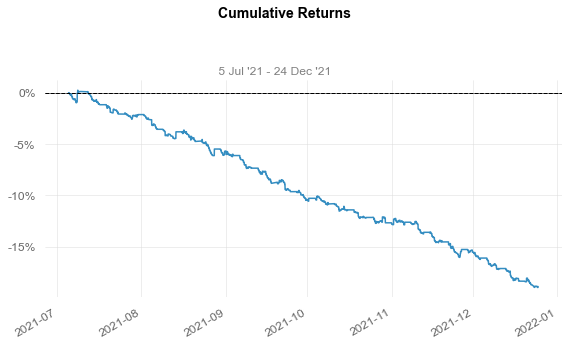

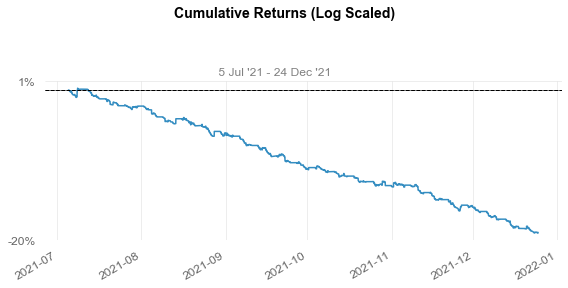

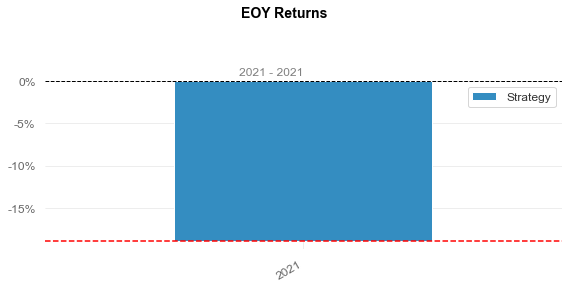

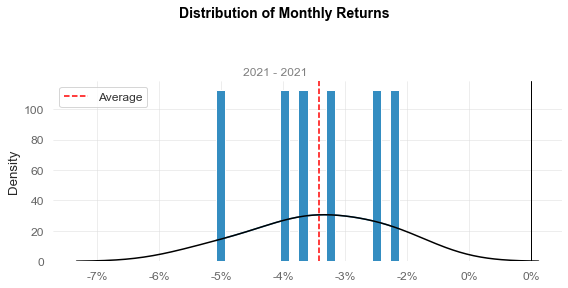

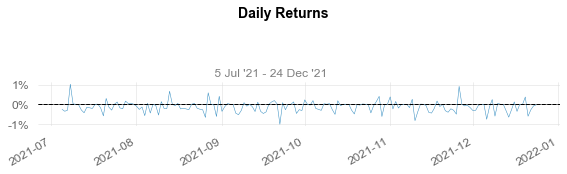

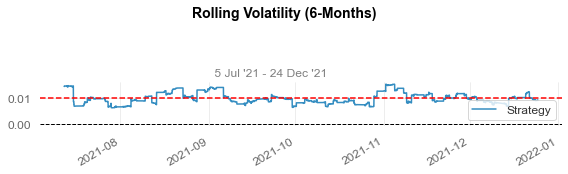

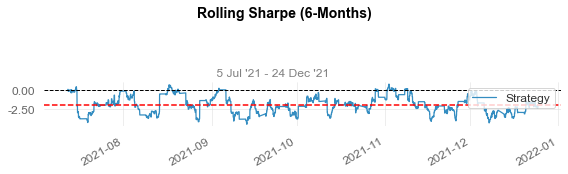

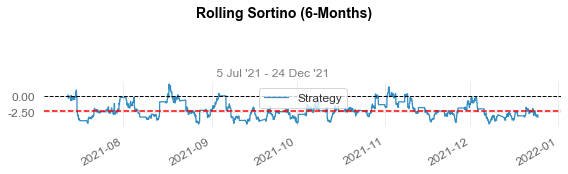

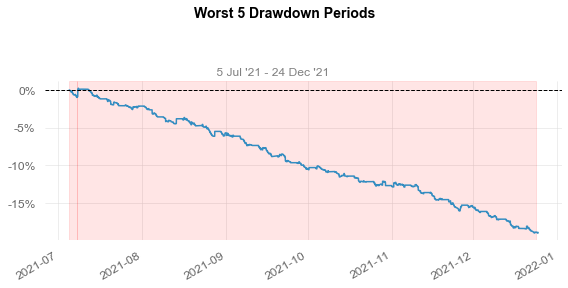

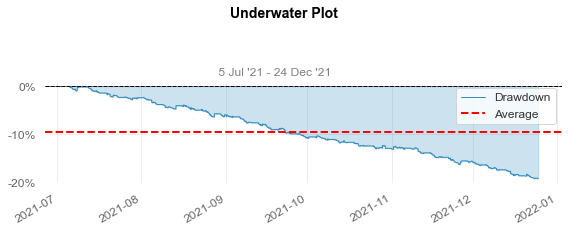

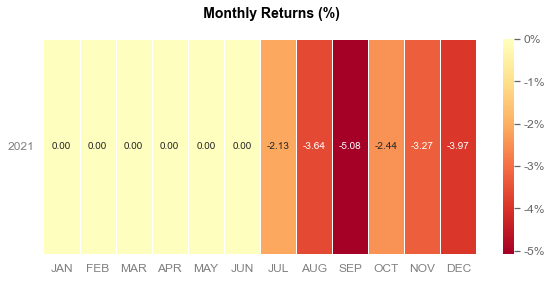

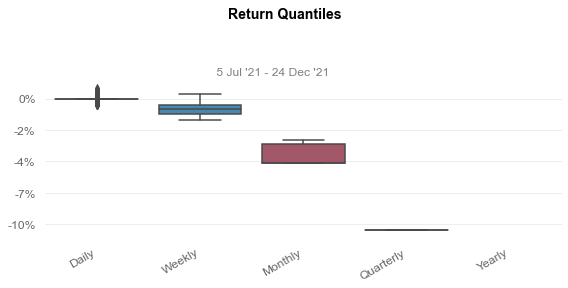

In [85]:
qs.reports.full(top_performance[names[5]]['iter_2_A2C_MlpLnLstmPolicy'])

                           Strategy
-------------------------  ----------
Start Period               2021-07-05
End Period                 2021-12-24
Risk-Free Rate             0.0%
Time in Market             25.0%

Cumulative Return          1.01%
CAGR﹪                     2.15%

Sharpe                     0.11
Smart Sharpe               0.11
Sortino                    0.16
Smart Sortino              0.16
Sortino/√2                 0.11
Smart Sortino/√2           0.11
Omega                      1.04

Max Drawdown               -2.55%
Longest DD Days            158
Volatility (ann.)          0.83%
Calmar                     0.84
Skew                       0.34
Kurtosis                   40.12

Expected Daily %           0.0%
Expected Monthly %         0.17%
Expected Yearly %          1.01%
Kelly Criterion            2.02%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.09%
Expected Shortfall (cVaR)  -0.09%

Gain/Pain Ratio            0.08
Gain/Pain (1M)             0.56



None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-07-19,2021-10-19,2021-12-24,158,-2.553546,-2.452703
2,2021-07-13,2021-07-13,2021-07-15,1,-0.268116,-0.229782
3,2021-07-07,2021-07-07,2021-07-08,1,-0.144469,-0.111727
4,2021-07-09,2021-07-09,2021-07-12,3,-0.133861,-0.128831
5,2021-07-15,2021-07-16,2021-07-16,0,-0.108654,-0.063593


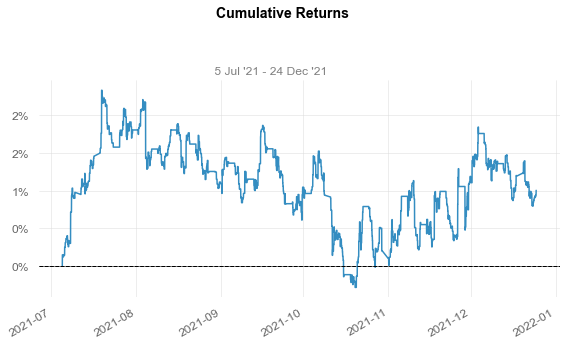

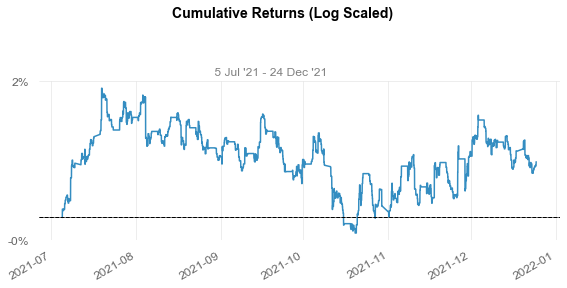

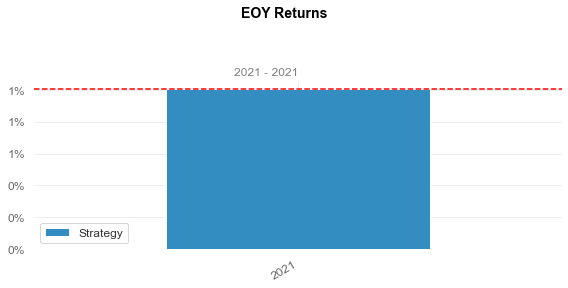

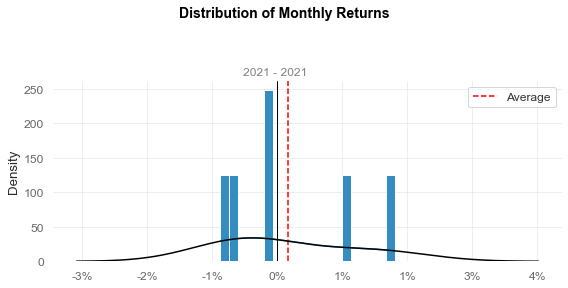

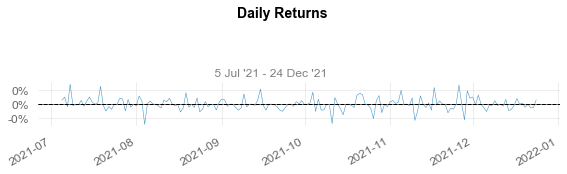

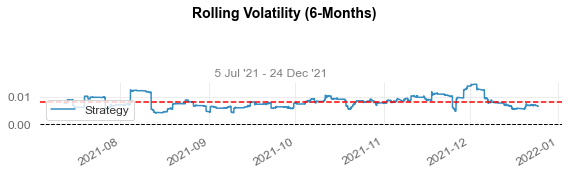

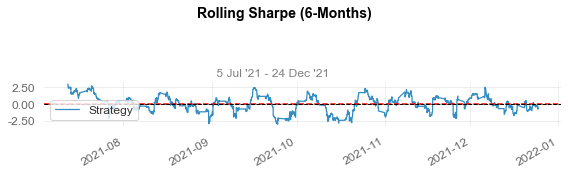

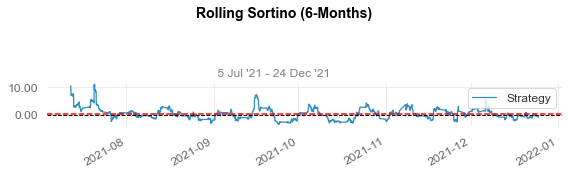

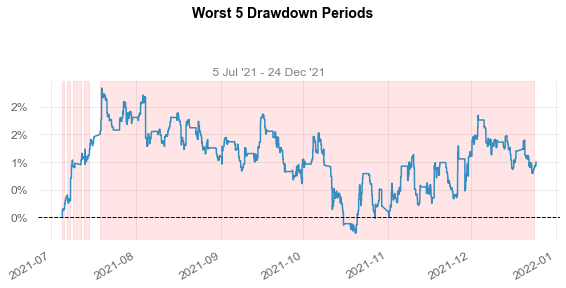

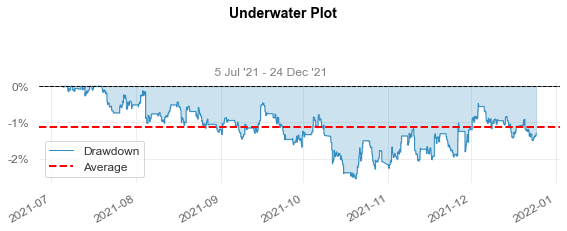

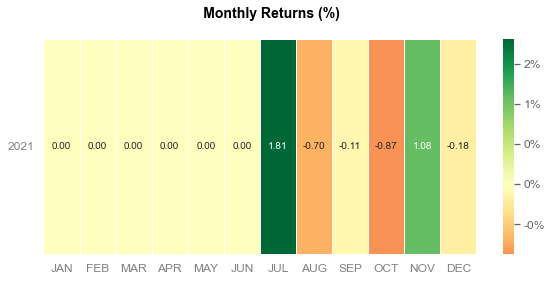

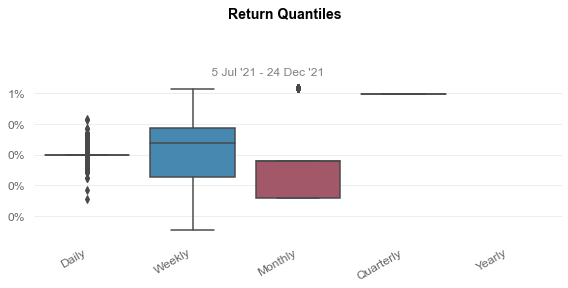

In [86]:
qs.reports.full(top_performance[names[6]]['iter_1_A2C_MlpLstmPolicy'])

In [87]:
names

['AUDUSD', 'EURUSD', 'GBPUSD', 'NZDUSD', 'USDCAD', 'USDCHF', 'USDJPY']